In [19]:
import importlib
import utils
importlib.reload(utils)
from utils import *

In [18]:
import os
import pandas as pd
TRAIN_DF_FILE_PATH = os.path.join("../datasets/FccIQ/synthetic/train_df.csv")
print("TRAIN_DF_FILE_PATH: ", TRAIN_DF_FILE_PATH)
train_df = pd.read_csv(TRAIN_DF_FILE_PATH)
print(f'train_df.shape: {train_df.shape}')
print(train_df.head())

trains = load_train_dataset(train_df)
print(f'trains.shape: {trains.shape}')


TRAIN_DF_FILE_PATH:  ../datasets/FccIQ/synthetic/train_df.csv
train_df.shape: (9844, 7)
   SNR  SIR  MCS  FRQ  Slot  \
0    1   -1    1   -1     1   
1    1   -1    1   -1     2   
2    1   -1    1   -1     4   
3    1   -1    1   -1     5   
4    1   -1    1   -1     6   

                                           file_path  ground_truth_file_path  
0  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                     NaN  
1  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                     NaN  
2  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                     NaN  
3  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                     NaN  
4  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                     NaN  
trains.shape: torch.Size([9844, 2, 300, 14])


/home/vantuan_ngo/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8400.
  res = hypotest_fun_out(*samples, **kwds)


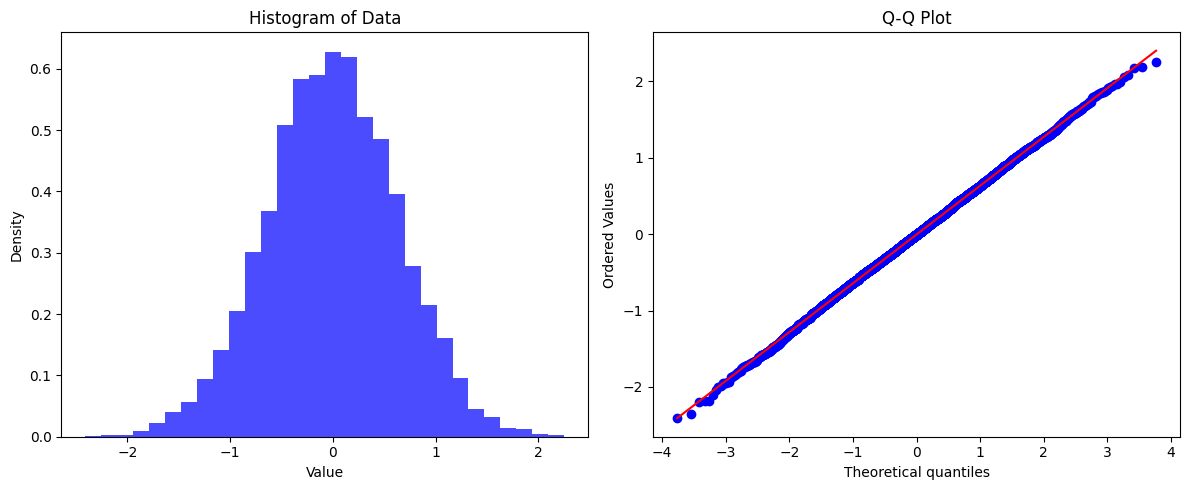

Gaussian count: 9109/9844


In [3]:
import numpy as np

gaussian_count = 0
for i in range(len(trains)):
    if i == 0:
        result = check_gaussian(trains[i].numpy().flatten(), plot=True)
    else:
        result = check_gaussian(trains[i].numpy().flatten(), plot=False)
    if result['interpretation_binary'] == 1:
        gaussian_count += 1
print(f"Gaussian count: {gaussian_count}/{len(trains)}")

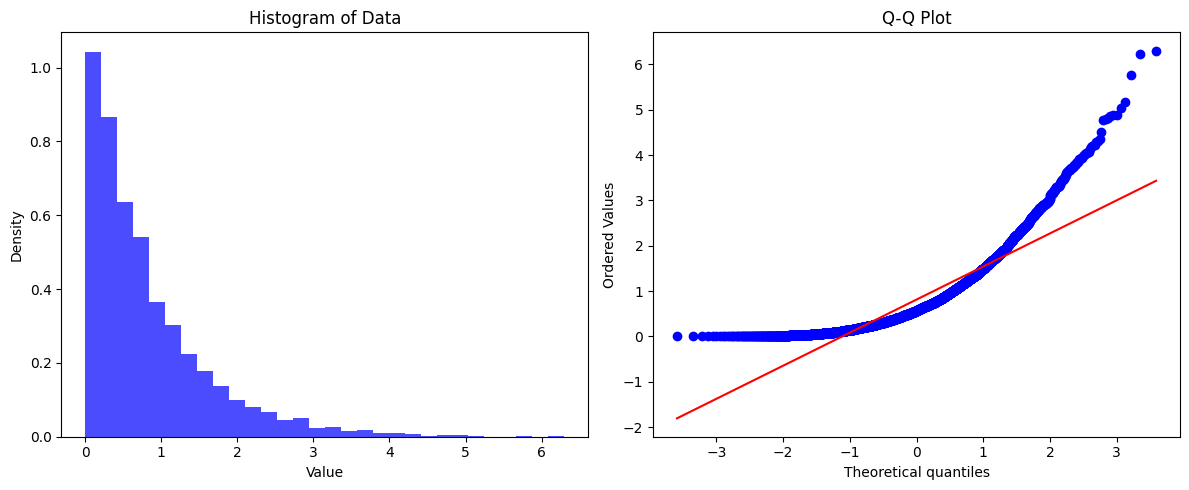

Gaussian count: 0/9844


In [4]:
import torch

gaussian_count = 0
for i in range(len(trains)):
    if i == 0:
        result = check_gaussian(torch.sum(trains[i]**2, axis=0).numpy().flatten(), plot=True)
    else:
        result = check_gaussian(torch.sum(trains[i]**2, axis=0).numpy().flatten(), plot=False)
    if result['interpretation_binary'] == 1:
        gaussian_count += 1
print(f"Gaussian count: {gaussian_count}/{len(trains)}")

Processing training samples:   0%|          | 0/9844 [00:00<?, ?it/s]

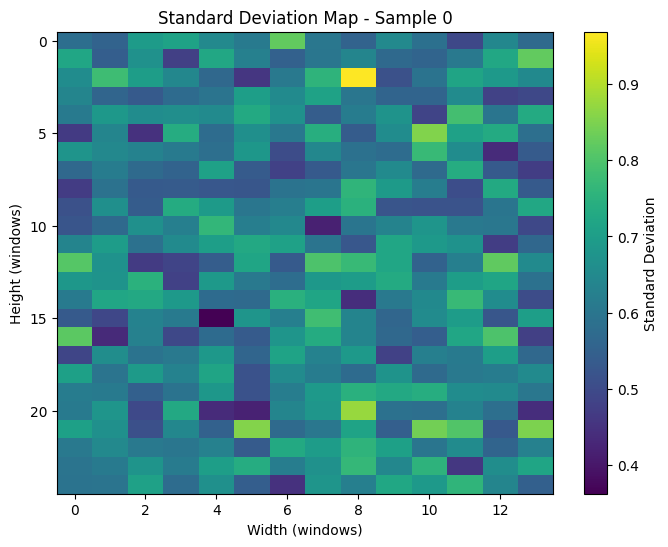

Processing training samples: 100%|██████████| 9844/9844 [01:15<00:00, 129.70it/s]

anomaly_score.shape: 9844
anomaly_threshold: 0.8623988032341003


In [31]:
import torch
import matplotlib.pyplot as plt

anomaly_scores = []
from tqdm import tqdm

for idx, train in enumerate(tqdm(trains, desc="Processing training samples")):

    anomaly_score, std_image = get_anomaly_score(train)
    anomaly_scores.append(anomaly_score)

    # Plot the standard deviation image
    if idx == 0:
        plt.figure(figsize=(8, 6))
        plt.imshow(std_image.numpy(), cmap='viridis', aspect='auto')
        plt.colorbar(label='Standard Deviation')
        plt.title(f'Standard Deviation Map - Sample {idx}')
        plt.xlabel('Width (windows)')
        plt.ylabel('Height (windows)')
        plt.show()
        plt.close()
    
    # if idx == 100:
    #     break

print(f"anomaly_score.shape: {len(anomaly_scores)}")
anomaly_threshold = np.percentile(anomaly_scores, 99)
print(f"anomaly_threshold: {anomaly_threshold}")

In [42]:
TEST_DF_FILE_PATH = os.path.join("../datasets/FccIQ/synthetic/test_df.csv")
print("TEST_DF_FILE_PATH: ", TEST_DF_FILE_PATH)
test_df = pd.read_csv(TEST_DF_FILE_PATH)
print(f'test_df.shape: {test_df.shape}')
print(test_df.head())

test_df = test_df[test_df['SNR'] == 2]
# print(f'test_df.shape: {test_df.shape}')

test_df['INR'] = test_df['SNR'] - test_df['SIR']
print(test_df.head())

inrs = test_df['INR'].unique()
inrs.sort()
print(f'inrs: {inrs}')

map_inr_accuracy = {}
map_inr_precision = {}
map_inr_recall = {}
map_inr_f1_score = {}

for inr in inrs:
    print(f'inr: {inr}')
    test_df_inr = test_df[test_df['INR'] == inr]
    tests, test_labels = load_test_dataset(test_df_inr)
    print(f'tests.shape: {tests.shape}')
    print(f'test_labels.shape: {test_labels.shape}')

    print(f"test_labels unique values: {np.unique(test_labels)}")
    print(f"test_labels value counts:")
    for label in np.unique(test_labels):
        count = (test_labels == label).sum().item()
        print(f"  Label {label}: {count} samples ({count/len(test_labels)*100:.1f}%)")

    tn = 0
    fp = 0
    fn = 0
    tp = 0
    for idx, test in enumerate(tests):
        anomaly_score, std_image = get_anomaly_score(test)
        if anomaly_score > anomaly_threshold:
            verdict = 1
        else:
            verdict = 0
        if verdict == test_labels[idx]:
            if verdict == 1:
                tp += 1
            else:
                tn += 1
        else:
            if verdict == 1:
                fp += 1
            else:
                fn += 1
    print(f'tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}')
    
    # Calculate accuracy (always safe since denominator is total samples)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print(f'accuracy: {accuracy}')
    map_inr_accuracy[inr] = accuracy
    
    # Calculate precision (check for division by zero)
    if (tp + fp) > 0:
        precision = tp / (tp + fp)
        print(f'precision: {precision}')
        map_inr_precision[inr] = precision
    else:
        print('precision: undefined (no positive predictions)')
    
    # Calculate recall (check for division by zero)
    if (tp + fn) > 0:
        recall = tp / (tp + fn)
        print(f'recall: {recall}')
        map_inr_recall[inr] = recall
    else:
        print('recall: undefined (no actual positives)')
    
    # Calculate F1 score (check for division by zero)
    if (2 * tp + fp + fn) > 0:
        f1_score = 2 * tp / (2 * tp + fp + fn)
        print(f'f1_score: {f1_score}')
        map_inr_f1_score[inr] = f1_score
    else:
        print('f1_score: undefined (no predictions or actual positives)')

print(f'map_inr_accuracy: {map_inr_accuracy}')
print(f'map_inr_precision: {map_inr_precision}')
print(f'map_inr_recall: {map_inr_recall}')
print(f'map_inr_f1_score: {map_inr_f1_score}')

TEST_DF_FILE_PATH:  ../datasets/FccIQ/synthetic/test_df.csv
test_df.shape: (23374, 7)
   SNR  SIR  MCS  FRQ  Slot  \
0    1   -1    1   -1     3   
1    1   -1    1   -1    11   
2    1   -1    1   -1    12   
3    1   -1    1   -1    17   
4    1   -1    1   -1    21   

                                           file_path ground_truth_file_path  
0  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                    NaN  
1  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                    NaN  
2  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                    NaN  
3  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                    NaN  
4  /home/vantuan_ngo/anomalib-example/FccIQ/../da...                    NaN  
    SNR  SIR  MCS  FRQ  Slot  \
78    2   -1    1   -1     5   
79    2   -1    1   -1    10   
80    2   -1    1   -1    13   
81    2   -1    1   -1    19   
82    2   -1    1   -1    42   

                                            file_path ground_truth

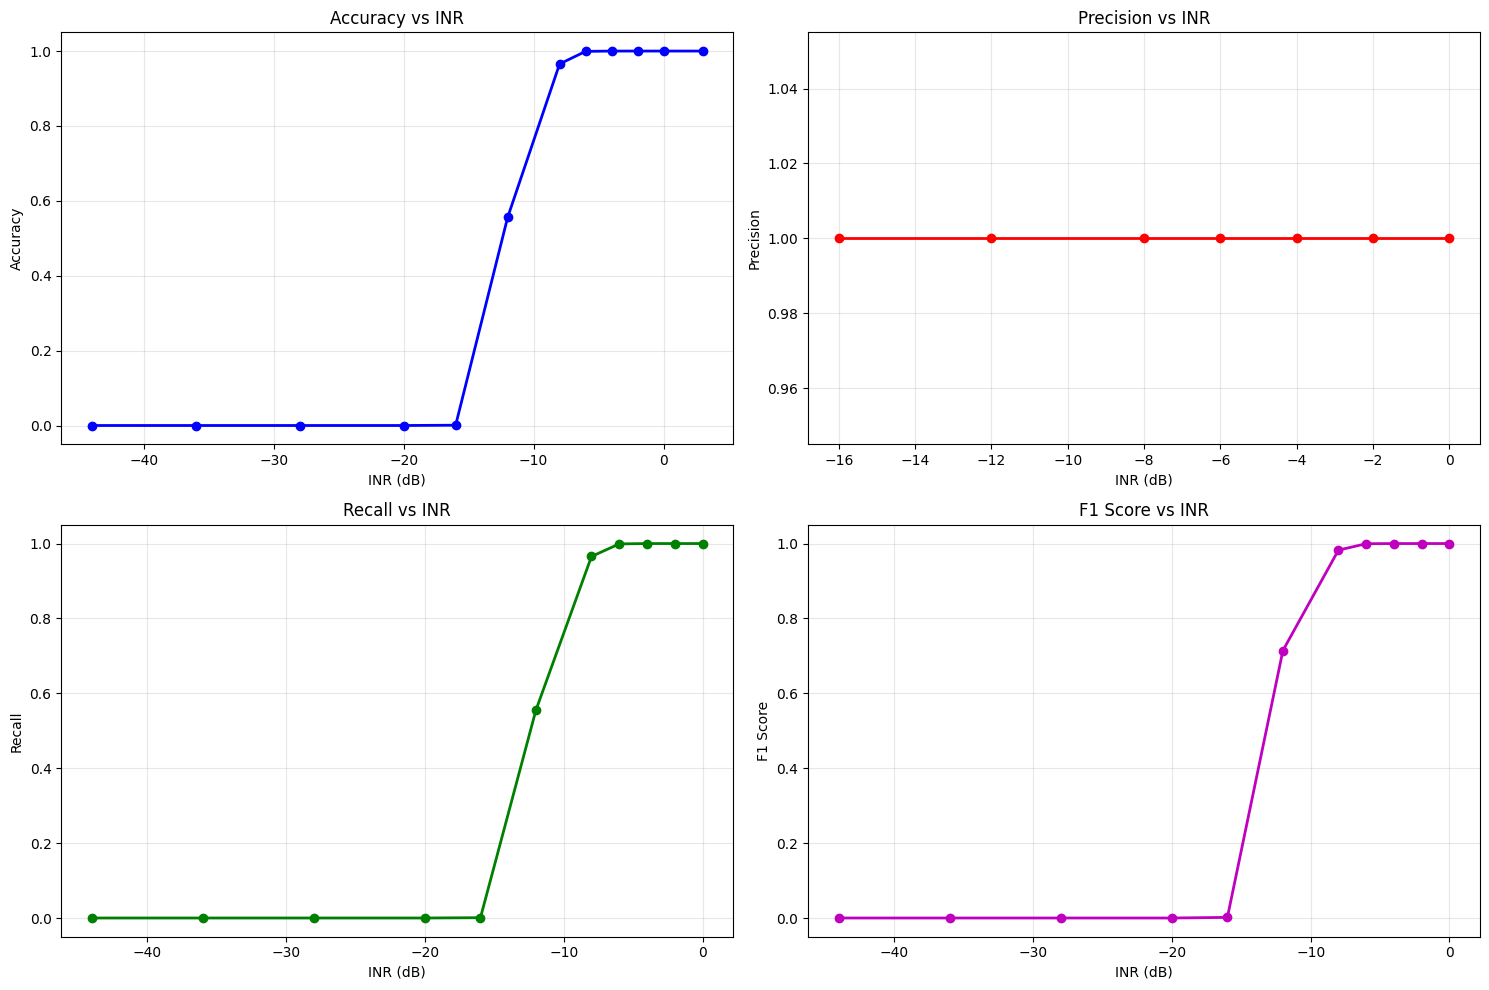


Summary Statistics:
Best Accuracy: 1.0000 at INR = -4 dB
Best Precision: 1.0000 at INR = -44 dB
Best Recall: 1.0000 at INR = -4 dB
Best F1 Score: 1.0000 at INR = -4 dB


In [43]:
# Plot the results
plt.figure(figsize=(15, 10))

# Plot accuracy
plt.subplot(2, 2, 1)
inr_values = list(map_inr_accuracy.keys())
accuracy_values = list(map_inr_accuracy.values())
plt.plot(inr_values, accuracy_values, 'bo-', linewidth=2, markersize=6)
plt.xlabel('INR (dB)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs INR')
plt.grid(True, alpha=0.3)

# Plot precision
plt.subplot(2, 2, 2)
inr_values = list(map_inr_precision.keys())
precision_values = list(map_inr_precision.values())
plt.plot(inr_values, precision_values, 'ro-', linewidth=2, markersize=6)
plt.xlabel('INR (dB)')
plt.ylabel('Precision')
plt.title('Precision vs INR')
plt.grid(True, alpha=0.3)

# Plot recall
plt.subplot(2, 2, 3)
inr_values = list(map_inr_recall.keys())
recall_values = list(map_inr_recall.values())
plt.plot(inr_values, recall_values, 'go-', linewidth=2, markersize=6)
plt.xlabel('INR (dB)')
plt.ylabel('Recall')
plt.title('Recall vs INR')
plt.grid(True, alpha=0.3)

# Plot F1 score
plt.subplot(2, 2, 4)
inr_values = list(map_inr_f1_score.keys())
f1_values = list(map_inr_f1_score.values())
plt.plot(inr_values, f1_values, 'mo-', linewidth=2, markersize=6)
plt.xlabel('INR (dB)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs INR')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Best Accuracy: {max(accuracy_values):.4f} at INR = {inr_values[accuracy_values.index(max(accuracy_values))]} dB")
print(f"Best Precision: {max(precision_values):.4f} at INR = {inr_values[precision_values.index(max(precision_values))]} dB")
print(f"Best Recall: {max(recall_values):.4f} at INR = {inr_values[recall_values.index(max(recall_values))]} dB")
print(f"Best F1 Score: {max(f1_values):.4f} at INR = {inr_values[f1_values.index(max(f1_values))]} dB")
